<a href="https://colab.research.google.com/github/Rubendiazolmo/BloquePID/blob/main/IdentificacionPID2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import output
!pip install scipy
output.clear()
!pip install control
output.clear()
!pip install pandas
output.clear()
!pip install numpy
output.clear()
!pip install matplotlib
output.clear()
!pip install --upgrade --force-reinstall xlrdoutput.clear()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 398 kB 5.9 MB/s 
  Created wheel for control: filename=control-0.9.2-py2.py3-none-any.whl size=403205 sha256=a14495bb61f3382d8b3898fcca0a205d04c989022973bafd5c9e6549c1d27b6d
  Stored in directory: /root/.cache/pip/wheels/48/ef/c2/929bb5c59a1328df00a0561d0e68cd7c8537f33f5ce0ce741b
Successfully built control
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.8 MB/s 
  

In [2]:
# Importar módulos
from scipy.optimize import curve_fit
from scipy.signal import lti
from control.matlab import tf
from control.matlab import rlocus
from control import pole
from control import step_response
from control import forced_response as lsim
import pandas as pd
from numpy import *
from matplotlib.pyplot import *
from time import time
import io

In [3]:
# Función de transferencia de segundo orden para identificación
def FdT(x,k,w,r):
    sol = lti(-15*k*(w**2),[1, 2*r*w, w**2]).step(T=x)[1]-45
    return sol
 
# Función para integrar
def integrar(datos, integral):
    i1 = dt * (datos[2] + datos[1]) / 2
    i2 = dt * ((datos[2]) + (2 * datos[1]) + datos[0]) / 4
    integral = integral + (4 * i1 - i2) / 3
    return integral

# Función para derivar
def derivar(datos, tiempo_muestreo):
    sol = ((3 * datos[0]) - (4 * datos[1]) + datos[2]) / (2 * tiempo_muestreo)
    return sol

# Función para borrar NaN
def quitarNaN(data):
    tmp = isnan(data)
    datos_filtrados = data
    for i in range(len(tmp)):

        if tmp[i] == False:
            pass
        else:
            datos_filtrados = data[0:i]
            break

    return datos_filtrados

In [4]:
from google.colab import files
excel = files.upload()

datos = pd.read_excel(io.BytesIO(excel['datos.xls']))
respuesta_ba = array(datos['Respuesta'])
tiempo = array(datos["Tiempo"])

tiempo = quitarNaN(tiempo)
respuesta_ba = quitarNaN(respuesta_ba)

Saving datos.xls to datos.xls


In [5]:
par1, _ = curve_fit(FdT, tiempo, respuesta_ba)
k = par1[0]
w = par1[1]
r = par1[2]

fdt = tf(k*(w**2),[1, 2*r*w, w**2])
print(fdt)

A, B = pole(fdt-45)
print(A, B)


       -9.523
---------------------
s^2 + 2.673 s + 5.125

(-1.3367496888393555+1.8271102681673337j) (-1.3367496888393555-1.8271102681673337j)


1.357


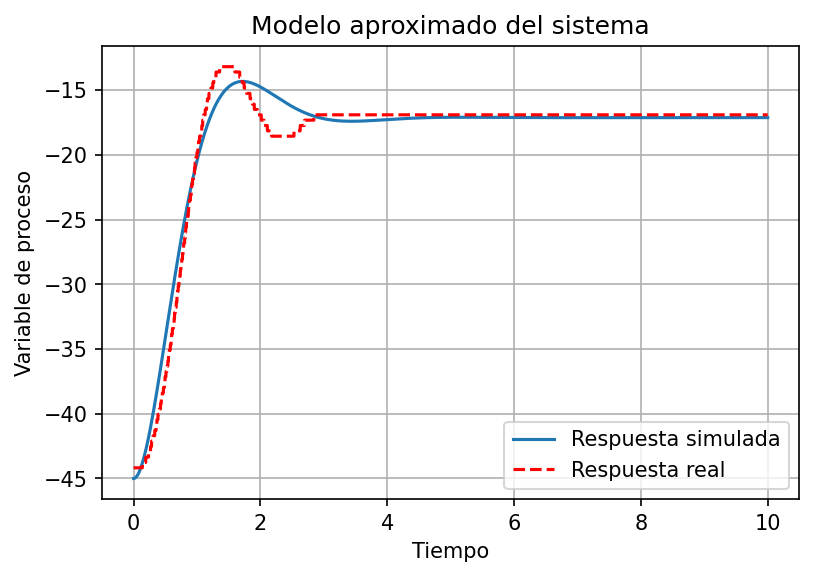

In [6]:
_,rsp = step_response(-15*fdt-45,tiempo)
figure(dpi=150)
title('Modelo aproximado del sistema')
grid()
ylabel('Variable de proceso')
xlabel('Tiempo')
plot(tiempo,rsp, label='Respuesta simulada')
plot(tiempo,respuesta_ba, '--', color='red', label='Respuesta real')
legend()
for i in range(len(respuesta_ba)-1):
    if respuesta_ba[i] == max(respuesta_ba):
        print(tiempo[i])
        break

Tiempo de ejecución =  0.8519563674926758 s


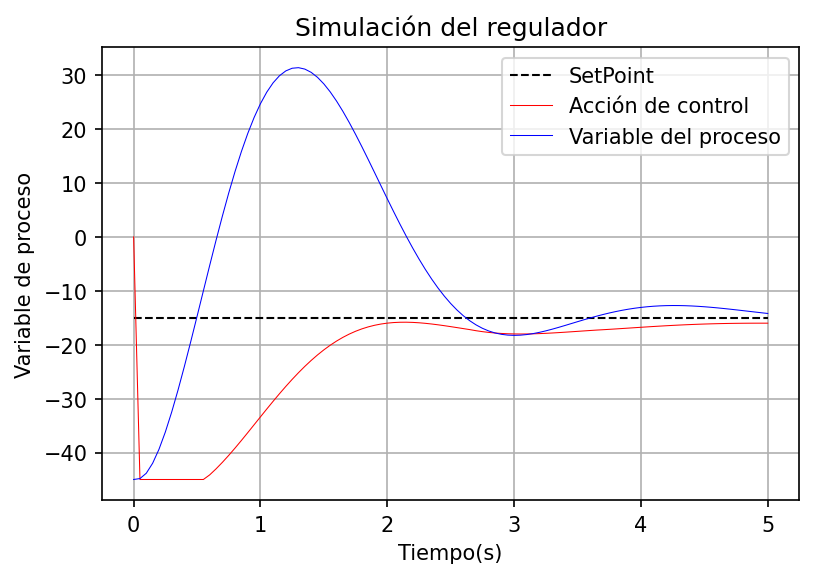

In [22]:

# Variables simulación

dt = 0.05
tiempo_simulacion = 5

# Definición de las constantes de regulación

inicio = time() # tic

coeficiente_amortiguamiento = 2

# kp = (((A+B)/(2*coeficiente_amortiguamiento))**2/(A*B)).real
kp = 0.225
ti = .45 
td = 0.25

tipo_regulador = 2
# 1 = P, 2 = PI, 3 = PD, 4 = PID #

'''
# Obtención de la ganancia crítica del sistesma a través del lugar de las raices
if tipo_regulador == 1:
    for i in range(len(raices)):
        if raices[i][0].imag != 0 and raices[i][1].imag != 0 :
            kp = ganancia[i-1]
            break
'''

# Definición de las variables necesarias para simular el regulador
setpoint = -15

u = zeros(int((tiempo_simulacion/dt)+1))
t = zeros(int((tiempo_simulacion/dt)+1))
error = zeros(3)
proceso = zeros(3)
accion_control = -45
integral_error = 0
tmp = 0
y = [-45]
i = 1

# Simulación
while max(t) < tiempo_simulacion:
    tmp = len(y) - 1
    error[0] = setpoint - y[tmp]  # y(tmp) = valor actual del sistema
    proceso[0] = y[tmp]

    accion_control = error[0] * kp
    
    # "Anti Wind-Up" #
    if -45 <= accion_control <= 0: # Integrar cuando la acción de control no este saturada
        integral_error = integrar(error, integral_error)
#         integral_error = clip(integral_error, -45, 0)
        
    # integral_error = integrar(error, integral_error)
    derivada = derivar(error, dt)
    
    accion_proporcional = (kp * error[0])
    accion_integral = ((kp / ti) * integral_error)
    accion_derivada = (kp * td * derivada)

    if tipo_regulador   == 1:
        accion_control =(accion_proporcional)  # P
    elif tipo_regulador == 2:
        accion_control =((accion_proporcional) + accion_integral) # PI
    elif tipo_regulador == 3:
        accion_control = ((accion_proporcional) + (accion_derivada)) # PD
    elif tipo_regulador == 4:
        accion_control = ((accion_proporcional) + (accion_integral) + (accion_derivada))  # PID
    
    accion_control = clip(accion_control, -45, 0)  
    # Limitar acción de control simulando saturación

    u[i] = (-45) - accion_control
    t[i] = dt * i

    x ,y = (lsim(fdt, t[0:i+1], u[0:i+1]))
    y -= 45
    
    error[2] = error[1]
    error[1] = error[0]
    proceso[2] = proceso[1]
    proceso[1] = proceso[0]

    i += 1

fin = time() #toc
print('Tiempo de ejecución = ', fin-inicio, 's')
    
figure(dpi=150)
    
# Plot del setpoint
setpoint_plot = np.linspace(setpoint, setpoint, len(t))
plot(t,setpoint_plot, '--', linewidth=1, color='black', label = 'SetPoint')

# Plot de la simulación del regulador
plot(t, u, color='red', label='Acción de control', linewidth=0.5)  # Accion de control
plot(t, y, color='blue', label='Variable del proceso', linewidth=0.5)  # Variable de proceso
title('Simulación del regulador')
grid()
xlabel('Tiempo(s)')
ylabel('Variable de proceso')
legend()
